In [4]:

import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [5]:
train_size = 0.01 # train size chosen to have a few tousands of elements
cutoff_variance = .9 # the total amount of variance explained by the selected transformed features
cv = 5
random_state = 42
np.random.seed(random_state) # this sets the random sequence. Setting only this the repeatability is guaranteed
                             # only if we re-execute the entire notebook

train_ds = pd.read_csv('../data/train.csv')
test_ds = pd.read_csv('../data/test.csv')

print("Shape of the training data {}".format(train_ds.shape))
print("Shape of the test data {}".format(test_ds.shape))

Shape of the training data (200000, 77)
Shape of the test data (100000, 76)


In [6]:
# show 10 random records
train_ds.sample(n=10, axis=0, replace=False, random_state = random_state)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
119737,119737,0,0,15,0,0,0,0,0,11,0,2,0,1,0,0,0,0,0,2,0,0,0,6,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,3,0,0,0,3,0,0,3,0,0,0,34,0,0,0,0,0,3,1,0,0,0,0,0,0,1,0,0,0,1,0,0,Class_3
72272,72272,0,0,1,0,0,1,0,0,0,1,2,0,2,0,3,0,3,0,3,0,0,0,0,0,1,10,0,0,3,0,0,5,0,1,0,2,0,1,1,0,6,0,0,1,7,0,1,0,0,4,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,3,0,0,0,0,Class_6
158154,158154,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,0,4,0,0,1,0,0,0,0,0,2,0,0,0,0,0,36,0,0,1,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,Class_6
65426,65426,6,0,0,0,0,2,0,0,0,0,0,0,7,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,1,1,1,0,0,0,0,6,0,4,2,0,0,5,3,0,3,0,0,0,2,0,1,2,15,1,3,0,0,0,0,0,0,1,0,0,3,7,2,1,0,0,0,1,1,Class_8
30074,30074,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,5,0,0,0,3,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,Class_1
23677,23677,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,8,0,0,0,2,1,0,1,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_2
134858,134858,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2,3,0,5,0,0,2,2,0,0,0,0,0,0,2,0,0,0,0,0,5,0,0,0,0,0,0,0,0,12,0,0,1,0,0,7,0,0,4,1,0,0,0,1,0,0,0,0,0,0,2,0,1,0,0,0,Class_9
176418,176418,0,0,0,0,0,14,0,0,0,0,0,1,0,0,0,0,0,0,0,16,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,0,0,0,Class_2
132467,132467,0,2,1,3,1,0,0,7,8,2,4,0,0,1,1,1,1,0,4,3,3,0,0,4,2,0,1,5,2,3,2,7,2,3,0,4,6,34,15,0,1,0,1,2,5,1,4,0,15,11,2,2,2,3,14,0,6,1,15,0,4,2,1,6,2,1,0,1,0,0,20,18,1,0,1,Class_8
4082,4082,40,0,0,0,0,0,0,2,0,72,1,0,0,4,4,6,1,0,5,12,0,0,11,0,0,0,0,1,0,1,1,1,2,2,0,0,1,1,0,1,0,2,0,1,0,0,0,0,0,0,10,0,0,2,2,0,4,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,Class_5


In [7]:
train_ds.nunique().sort_values(ascending=False)[:30]

id            200000
feature_15       105
feature_60        99
feature_59        92
feature_73        91
feature_46        87
feature_28        78
feature_32        77
feature_54        72
feature_61        70
feature_63        70
feature_19        66
feature_55        65
feature_47        63
feature_62        61
feature_3         59
feature_29        58
feature_67        57
feature_41        56
feature_22        55
feature_5         55
feature_43        53
feature_69        52
feature_9         51
feature_24        50
feature_74        50
feature_70        49
feature_27        49
feature_51        49
feature_2         48
dtype: int64

In [8]:
target = 'target'
classes = train_ds[target].unique()
classes.sort()
print(classes)

['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']


In [9]:
le = LabelEncoder()
y = le.fit_transform(train_ds[target])
X = train_ds.drop(['id', target], axis=1)
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,0,0,6,1,0,0,0,0,7,0,0,0,3,0,1,0,0,3,3,1,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,11,0,0,0,0,0,9,0,0,0,0,0,0,3,0,1,3,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,5,0,5,0,1,0,0,0,1,0,0,1,0,7,0,1,1,0,3,4,0,0,1,3,0,2,0,0,8,0,0,0,0,1,0,0,0,0
3,0,0,7,0,1,5,2,2,0,1,2,0,5,0,0,4,0,0,22,2,1,0,0,0,0,3,0,37,0,1,3,13,0,10,0,3,1,1,0,7,0,0,2,0,1,0,0,0,0,0,0,10,0,0,25,1,0,1,2,0,2,0,7,0,0,0,0,4,0,2,2,0,4,3,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
model_lbls = ['dt' # decision tree
             #,'nb' # gaussian naive bayes
             ,'rf'   # random forest
             #,'lp'   # linear perceptron
             #,'svc'  # support vector
             #,'knn'  # k nearest neighbours
             #,'adb'  # adaboost
            ]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-12,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state),
           'param': [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],
                    },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[20,30,40,50]
                     ,'learning_rate':[0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{
                      # 'max_depth': [*range(4,30)]
                      'max_depth': [*range(4,30,4)]
                    #  ,'n_estimators':[*range(20,80,5)]
                     ,'n_estimators':[*range(10,30,5)]
                     ,'class_weight': [None,'balanced']
                      }]
          }

}


In [11]:
from sklearn.model_selection import train_test_split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y
                                                    , train_size = train_size
                                                    , random_state = random_state) # default Train 0.75- Test 0.25
print("There are {} samples in the training dataset".format(X_train_full.shape[0]))
print("There are {} samples in the testing dataset".format(X_test_full.shape[0]))
print("Each sample has {} features".format(X.shape[1]))

There are 2000 samples in the training dataset
There are 198000 samples in the testing dataset
Each sample has 75 features


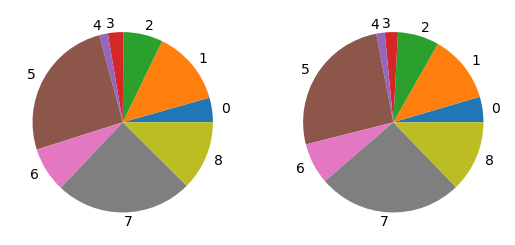

In [12]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
ax1.pie(np.unique(y_train, return_counts=True)[1], labels=np.unique(y_train, return_counts=True)[0]);
ax2.pie(np.unique(y_test, return_counts=True)[1], labels=np.unique(y_test, return_counts=True)[0]);
plt.show()

In [13]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

k_best = 30  # Number of top features to select
selector = SelectKBest(mutual_info_classif, k=k_best)
X_train = selector.fit_transform(X_train_full, y_train)
X_test = selector.transform(X_test_full)

In [14]:
scorings = ['accuracy'
            # ,'precision_macro'
            # ,'recall_macro'
            ,'f1_macro'
            ]

In [15]:
from sklearn.model_selection import ParameterGrid
trials = {lbl: len(list(ParameterGrid(models[lbl]['param']))) for lbl in model_lbls}
trials

{'dt': 38, 'rf': 56}

In [16]:
clfs = []
results = pd.DataFrame(columns=['scoring','model','best_params','accuracy','precision_macro','recall_macro','f1_macro'])


In [17]:
for score in scorings:
    for m in model_lbls:
        clf = GridSearchCV(
            estimator=models[m]['estimator'],
            param_grid=models[m]['param'],
            scoring=score,
            cv=cv,
        )
        clf.fit(X_train,y_train)
        clfs.append(clf)
        y_pred = clf.predict(X_test)
        clf_report = classification_report(y_test,y_pred, zero_division=1, output_dict=True)
        results.loc[len(results)] = [
            score,
            models[m]['name'],
            clf.best_params_,
            clf_report['accuracy'],
            clf_report['macro avg']['precision'],
            clf_report['macro avg']['recall'],
            clf_report['macro avg']['f1-score']
        ] 

In [18]:
for score in scorings:
    scoring_filter = score
    display(
        results[results.scoring==scoring_filter]\
        .drop('scoring',axis=1)\
        .sort_values(by=scoring_filter, ascending=False)\
        .style.format(precision=3)\
        .set_caption(' Resulta for scoring {}'.format(scoring_filter))
    )

,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
1,Random forest,"{'class_weight': None, 'max_depth': 8, 'n_estimators': 20}",0.330,0.153,0.171,0.136
0,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.310,0.576,0.157,0.125


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
3,Random forest,"{'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 20}",0.270,0.159,0.173,0.158
2,Decision Tree,"{'class_weight': None, 'max_depth': 14}",0.241,0.141,0.152,0.142


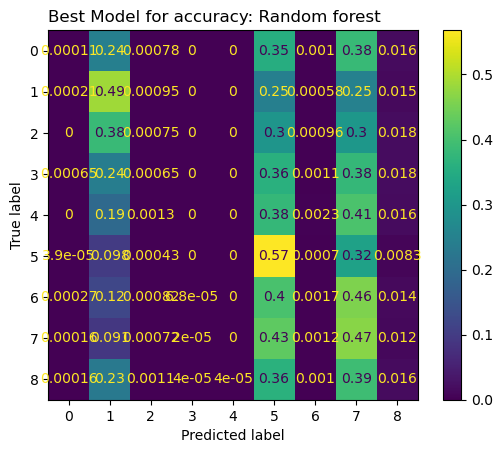

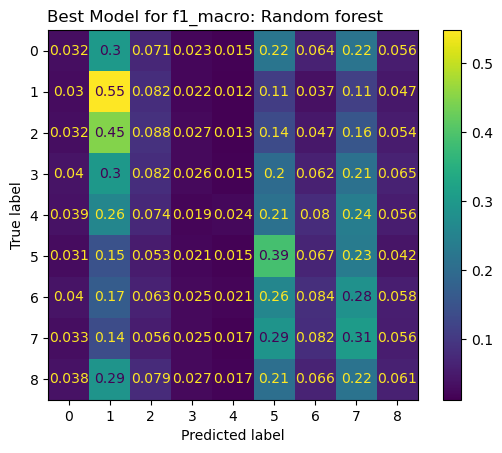

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

for score in scorings:
    scoring_filter = score
    best_row = results.loc[results.scoring==scoring_filter,scoring_filter].idxmax(axis=0)
    disp = ConfusionMatrixDisplay.from_estimator(clfs[best_row],X_test,y_test,normalize='true')
    disp.ax_.set_title("Best Model for {}: {}".format(score,results.at[best_row,'model']))